# GMM

Insipirado en caso del Libro "Python Data Science Handbook", de Jake VanderPlas (O'Reilly, 2017).

La segmentación de un dataset a partir de técnicas como **K-means** o **clustering jerárquico** tiene la particularidad de producir resultados absolutos (**hard clustering**): cada instancia pertenece completamente a un solo cluster, así se encuentre muy próxima a una frontera de particionamiento.

Los modelos generativos pueden utilizarse en clustering, relajando esta restricción (**soft clustering**), de tal manera que cada instancia puede tener un grado de pertenencia en menor o mayor grado a cada uno de los clusters encontrados.

Utilizando un dataset sintético, en este taller vamos a analizar la técnica llamada **GMM (Gaussian Mixture Models)** para el clustering que, partiendo de un número de clusters K a buscar, encuentra las K distribuciones gaussianas más acordes a los segmentos de datos que supuestamente pudieron haber generado el dataset de entrenamiento.

## Datos sintéticos en grupos esféricos

Cargamos las librerías

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

Una librería interesante para poder comprender conceptos específicos es **sklearn.datasets**, que incluye herramientas de conjuntos de datos, como pequeños datasets comunes precargados (e.g. iris, boston, diabetes, etc.), métodos de acceso rápido a datasets grandes del mundo real (e.g. KDD cup 99), y funciones de generación aleatoria de conjuntos de datos (e.g. make_blobs, make_classification, make_circles, make_moons).

Utilizando **make_blobs**, vamos a generar inicialmente un dataset con 400 puntos que conforman 4 grupos circulares de puntos en 2 dimensiones. Tenemos además las 4 clases reales que identifican la distribución de probabilidad utilizada para su generación:

In [2]:
X, y_true = make_blobs(n_samples=400, centers=4, cluster_std=0.60, random_state=0)
print(X[0:5,])
X = X[:, ::-1] # Cambio las coordenadas 
print(X[0:5,])

[[ 0.25006446  6.48826703]
 [-2.69798647  2.52194722]
 [-2.90007604  3.06877291]
 [ 0.70295058  4.31427482]
 [-2.53563494  2.38449945]]
[[ 6.48826703  0.25006446]
 [ 2.52194722 -2.69798647]
 [ 3.06877291 -2.90007604]
 [ 4.31427482  0.70295058]
 [ 2.38449945 -2.53563494]]


veamos como quedan los puntos generados:

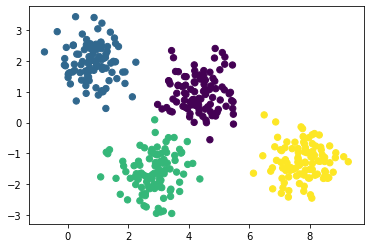

In [3]:
plt.scatter(X[:, 0], X[:, 1], c=y_true, s=40, cmap='viridis');

Si utilizásemos **K-Means** obtendriamos una categorización perfecta de los puntos en sus clases originales:

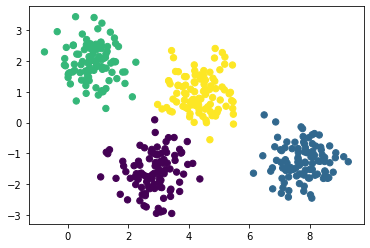

In [4]:
kmeans = KMeans(4, random_state=0)
y_pred_kmeans = kmeans.fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_pred_kmeans, s=40, cmap='viridis');

Vemos que encontramos 4 clusters que corresponden con las 4 categorías de instancias de las distribuciones del proceso generativo de puntos. Recordemos que el orden de estas clases es, al igual que todo el proceso de K-Means, aleatorio, por lo que no necesariamente los clusters encontrados se presenten en el mismo orden (otorgándoles diferencias de color en el plot).

Veamos cómo sería el clustering utilizando **GMM**, con K=4, identificando los primeros 5 puntos del dataset.
Especificando un valor de 'full' en el parámetro *covariance_type* indicamos que cada cluster a encontrar tiene una matriz de covarianza sin restricciones e independiente a la de los otros clusters. Otras posibilidades son 'tied' (todos los clusters comparten la misma matriz), 'diag' (matrices diagonales para cada cluster, produciendo elipses paralelas a los ejes), y 'spherical' (matrices diagonales con la misma varianza para cada eje).

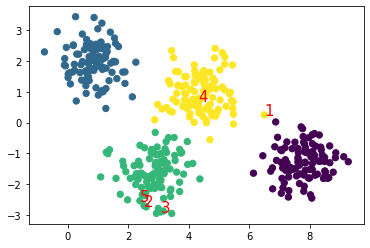

In [5]:
gmm = GaussianMixture(n_components=4, covariance_type='full').fit(X)
y_pred_gmm = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_pred_gmm, s=40, cmap='viridis');

for i in range(0,5):
    #ax.annotate(txt, (z[i], y[i]))
    #plt.text(x=x_text[], y=y_text, s="1");
    plt.text(x=X[i,0], y=X[i,1], s=i+1, color="red", size=15);


Visualmente identificamos solo 2 puntos diferentes, que se encuentran cerca de la frontera de decisión del cluster central con los clusters inferiores. Uno de ellos es el primero del dataset, que está marcado por el número **"1"**. 

Veamos ahora la probabilidad de pertenencia a los clusters creados utilizando la función **predict_proba**, que permite asignar a cada punto una probabilidad de pertenencia a cada cluster encontrado. Veamos como quedan las pertenencias de las primeras 5 instancias:

In [6]:
y_probas_gmm = gmm.predict_proba(X)
y_probas_gmm[0:5,:]

array([[4.69238090e-01, 1.75162717e-22, 2.76240973e-07, 5.30761633e-01],
       [1.97106146e-17, 4.71110558e-15, 9.99999999e-01, 9.22826700e-10],
       [2.34875746e-14, 3.07981606e-17, 9.99999998e-01, 2.09565089e-09],
       [5.27592131e-11, 5.00285665e-10, 9.15972926e-05, 9.99908402e-01],
       [3.86146363e-18, 5.28028479e-14, 9.99999998e-01, 1.69687673e-09]])

Encontramos que cada punto pertenece con menor o mayor grado a los 4 clusters. 
De particular interés es el primer punto, que tiene probabilidades altas aproximadads de pertenecer al cluster 4 de 53.1% y al cluster 2 de 46.9%, con unas probabilidades muy pequeñas de pertenecer al cluster 1 de 0.00003% y de 0 (cero de máquina) para el cluster 3. Esto indica que este punto esta muy cerca de la frontera de decisión. Recordemos que con K-Means, este punto había quedado organizado en el otro cluster.
Para los puntos 2, 3, 4 y 5, la pertenencia al cluster encontrado es mucho más claramente orientada hacia una sola clase, como también se puede confirmar gráficamente.

Una vez entrenado un objeto **GaussianMixture**, este permite consultar las siguientes variables:

- *weights_* : array con las proporciones de cada cluster
- *means_* : array con el centro (promedio) de cada cluster
- *covariances_* : matriz de varianzas / covarianzas de cada cluster
- *converged_* : indica si el algoritmo E-M pudo llegar a convergencia y encontrar así los parámetros de las distribuciones de los clusters
- *n_iter_*: número de iteraciones del algoritmo E-M para llegar a convergencia


In [7]:
gmm.weights_

array([0.24881629, 0.24967573, 0.24757933, 0.25392865])

In [8]:
gmm.means_

array([[ 7.76207921, -1.27617979],
       [ 0.8377989 ,  1.95781368],
       [ 2.84520475, -1.62515249],
       [ 4.36450124,  0.93400014]])

In [9]:
print(gmm.covariances_.shape)
gmm.covariances_

(4, 2, 2)


array([[[ 0.36544715,  0.01271038],
        [ 0.01271038,  0.28945443]],

       [[ 0.29790222, -0.02463781],
        [-0.02463781,  0.34185172]],

       [[ 0.38494452,  0.02843666],
        [ 0.02843666,  0.37794793]],

       [[ 0.40094166, -0.00447302],
        [-0.00447302,  0.36683582]]])

In [10]:
gmm.converged_

True

In [11]:
gmm.n_iter_

2

Veamos en el plot la probabilidad de la clase mayoritaria para cada uno de los puntos, reflejada en el tamaño del punto, además de una visualización de las elipses que ilustran la distribución de cada cluster en términos de centro y dispersión. Creamos dos funciones: *draw_ellipse*, que pinta y rellena las elipsis correspondientes a cada cluster dados sus centros y matrices de covarianzas de sus distribuciones, y *draw_gmm* que dado un clustering GMM ubica un conjunto de datos en cada cluster, pintando el resultado y llamando internamente a *draw_ellipse*.

In [13]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    ax = ax or plt.gca() # Obtenemos los ejes actuales de la figura si no se envían como parámetros
    
    # De las matrices de covarianzas se sacan los ejes principales y se determina su ángulo
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance) # Descomposición matricial, se obtienen ejes principales
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0])) # se calcula el ángulo entre ejes
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Se pinta la elipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height, angle, **kwargs))

In [14]:
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca() # Obtenemos los ejes actuales de la figura si no se envían como parámetros
    labels = gmm.fit_predict(X)
    probas = gmm.predict_proba(X)
    size = 50 * (probas.max(1)**3)
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=size, cmap='viridis', edgecolor='black', zorder=2)
    ax.set_aspect('equal') # para que los ejes queden con la misma escala
    factor = 0.2 / gmm.weights_.max() # controla el tamaño de las elipsis
    for centro, covarianza, peso in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(centro, covarianza, alpha= peso * factor)

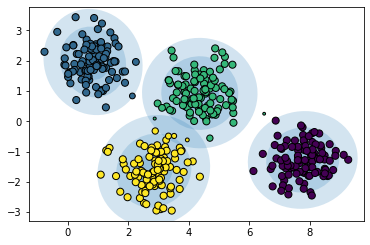

In [15]:
plot_gmm(gmm, X)

## Datos sintéticos en grupos estirados

Vamos a crear un nuevo conjunto de datos, también con 400 puntos, aglomerados en grupos estirados, para analizar los resultados de **GMM**. Nos basamos en la matriz original de datos esféricos, que vamos a deformar al multiplicarla por una matriz aleatoria cuya semilla buscamos hasta que nos permita obtener un resultado de datos estirados (incidentalmente, la semilla que nos permite esto fue 13).

In [16]:
rng = np.random.RandomState(13) # Generador aleatorio, vamos a utilizar una distribución normal estándar (randn)
X_stretched = np.dot(X, rng.randn(2, 2)) # randn retorna una matriz con datos aleatorios de una distribución estándar
X_stretched.shape

(400, 2)

Veamos como quedan los puntos generados con **KMeans**:

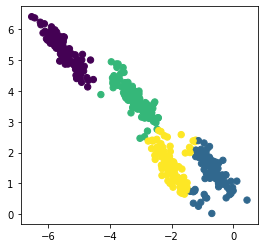

In [17]:
kmeans = KMeans(4, random_state=0)
y_pred_kmeans = kmeans.fit_predict(X_stretched)
plt.scatter(X_stretched[:, 0], X_stretched[:, 1], c=y_pred_kmeans, s=40, cmap='viridis');
ax = plt.gca()
ax.set_aspect('equal')

Y ahora con **GMM**:

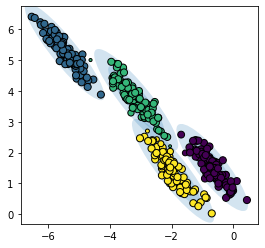

In [18]:
gmm = GaussianMixture(n_components=4)
y_pred_gmm = gmm.fit_predict(X_stretched)
plot_gmm(gmm, X_stretched)

## Determinación del número de clusters

Teniendo en cuenta que tenemos como base un modelo de generación de los datos probabilístico, podemos utilizar las métricas de ajuste por verosimilitud **AIC** y **BIC** para determinar el número ideal de clusters a buscar, así como el mejor valor de parámetro de destribución en cuanto a la forma de la covarianza a suponer.

Vamos a crear por ejemplo 21 modelos **GMM** con covarianza 'full' y escoger el número ideal de clusters (sabiendo que en este caso es 4).

Text(0.5, 1.0, 'Datos esféricos, full covarianza')

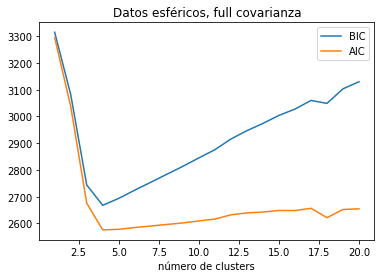

In [19]:
k_vec = np.arange(1, 21)
models = [GaussianMixture(k, covariance_type='full', random_state=0).fit(X) for k in k_vec]
plt.plot(k_vec, [m.bic(X) for m in models], label='BIC')
plt.plot(k_vec, [m.aic(X) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('número de clusters');
plt.title('Datos esféricos, full covarianza')

Text(0.5, 1.0, 'Datos esféricos, full covarianza')

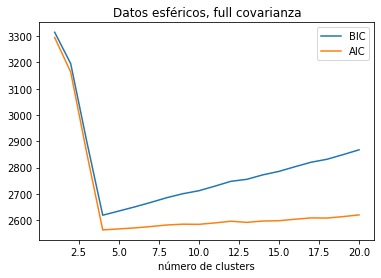

In [20]:
k_vec = np.arange(1, 21)
models = [GaussianMixture(k, covariance_type='tied', random_state=0).fit(X) for k in k_vec]
plt.plot(k_vec, [m.bic(X) for m in models], label='BIC')
plt.plot(k_vec, [m.aic(X) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('número de clusters');
plt.title('Datos esféricos, full covarianza')

Para los datos esféricos encontramos el mejor número de clusters de 4.

Comparemos con los datos estirados las covarianzas tipo 'full' y 'spherical'.

Text(0.5, 1.0, 'Datos estirados, full covarianza')

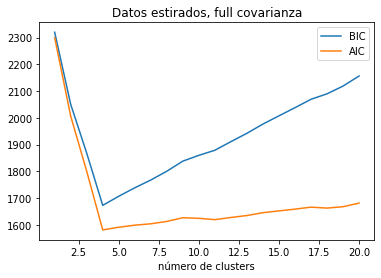

In [21]:
k_vec = np.arange(1, 21)
models = [GaussianMixture(k, covariance_type='full', random_state=0).fit(X_stretched) for k in k_vec]
plt.plot(k_vec, [m.bic(X_stretched) for m in models], label='BIC')
plt.plot(k_vec, [m.aic(X_stretched) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('número de clusters');
plt.title('Datos estirados, full covarianza')

Text(0.5, 1.0, 'Datos estirados, full covarianza')

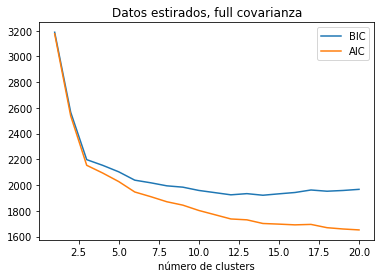

In [22]:
k_vec = np.arange(1, 21)
models = [GaussianMixture(k, covariance_type='spherical', random_state=0).fit(X_stretched) for k in k_vec]
plt.plot(k_vec, [m.bic(X_stretched) for m in models], label='BIC')
plt.plot(k_vec, [m.aic(X_stretched) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('número de clusters');
plt.title('Datos estirados, full covarianza')

Para los datos estirados, el mejor número de clusters es 5 con una covarianza 'full'.

De hecho, necesitamos determinar demasiados clusters con una covarianza 'spherical' para aproximarnos a los resultados de 'full